# Plot: optimal distance for forecasting the Lorenz system
for two different loww functions.

This notebook accompanies the following publication:
Paul Platzer, Arthur Avenas, Bertrand Chapron, Lucas Drumetz, Alexis Mouche, Léo Vinour. Distance Learning for Analog Methods. 2024. [⟨hal-04841334⟩](https://hal.science/hal-04841334)

It is used to plot optimized distance from numerical experiments with Lorenz system data (the results of "Notebook6"). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.neighbors import KDTree

In [2]:
# settings for plots
cols = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
matplotlib.rcParams.update({'font.size': 14})

In [3]:
data_folder = '../../data/lorenz/'
output_folder = '../../output/lorenz/'

# Load optimization results

In [4]:
npzfile = np.load(output_folder + 'optim_lorenz_crps.npz')

transform_optim_crps = npzfile['transform_optim_crps']
transform_optim_rmse = npzfile['transform_optim_rmse']
crps_optim = npzfile['crps_optim']
horizon = npzfile['horizon']
hh_ind = npzfile['hh_ind']

# Load catalog

In [5]:
npzfile = np.load(data_folder + 'catalog_small.npz')
traj_norm = npzfile['traj_norm']
stds = npzfile['stds']
tau = npzfile['tau']
dt = npzfile['dt']
Ntrain = npzfile['Ntrain']
h_max = npzfile['h_max']

# Make forecasts based on the optimized distances

In [6]:
# transform training explanatory variables 
train_init = traj_norm[::int(tau/dt)][:Ntrain]
train_crps_z = np.matmul(train_init, transform_optim_crps.T)
train_rmse_z = np.matmul(train_init, transform_optim_rmse.T)

# build KDTree
kdt_init = KDTree(train_init)
kdt_crps_z = KDTree(train_crps_z)
kdt_rmse_z = KDTree(train_rmse_z)

In [7]:
k = 200

Ntest = 10**4

# find analogues and related distances
dist_init, ind_init = kdt_init.query(train_init[:Ntest], k=k+1)
dist_init = dist_init[:,1:]; ind_init = ind_init[:,1:]

dist_crps_z, ind_crps_z = kdt_crps_z.query(train_crps_z[:Ntest], k=k+1)
dist_crps_z = dist_crps_z[:,1:]; ind_crps_z = ind_crps_z[:,1:]

dist_rmse_z, ind_rmse_z = kdt_rmse_z.query(train_rmse_z[:Ntest], k=k+1)
dist_rmse_z = dist_rmse_z[:,1:]; ind_rmse_z = ind_rmse_z[:,1:]

# Compute weights
dist_init_squared = dist_init**2
dist_crps_z_squared = dist_crps_z**2
dist_rmse_z_squared = dist_rmse_z**2

w_init = np.exp( - dist_init_squared.T + dist_init_squared[:,0] ).T # add the smallest distance to prevent from having zeros
w_crps_z = np.exp( - dist_crps_z_squared.T + dist_crps_z_squared[:,0] ).T # add the smallest distance to prevent from having zeros
w_rmse_z = np.exp( - dist_rmse_z_squared.T + dist_rmse_z_squared[:,0] ).T # add the smallest distance to prevent from having zeros

p_init = ( w_init.T / np.sum( w_init , axis = -1 ) ).T
p_crps_z = ( w_crps_z.T / np.sum( w_crps_z , axis = -1 ) ).T
p_rmse_z = ( w_rmse_z.T / np.sum( w_rmse_z , axis = -1 ) ).T

In [8]:
# Compute Fana(y)
Finit = np.sum( p_init * ((traj_norm[ind_init*int(tau/dt)+4,2].T
                           - traj_norm[4::int(tau/dt),2][:Ntest]).T < 0) , axis = 1 )
Fcrps = np.sum( p_crps_z * ((traj_norm[ind_crps_z*int(tau/dt)+4,2].T
                             - traj_norm[4::int(tau/dt),2][:Ntest]).T < 0) , axis = 1 )
Frmse = np.sum( p_rmse_z * ((traj_norm[ind_rmse_z*int(tau/dt)+4,2].T
                             - traj_norm[4::int(tau/dt),2][:Ntest]).T < 0) , axis = 1 )

# Plot figure 5

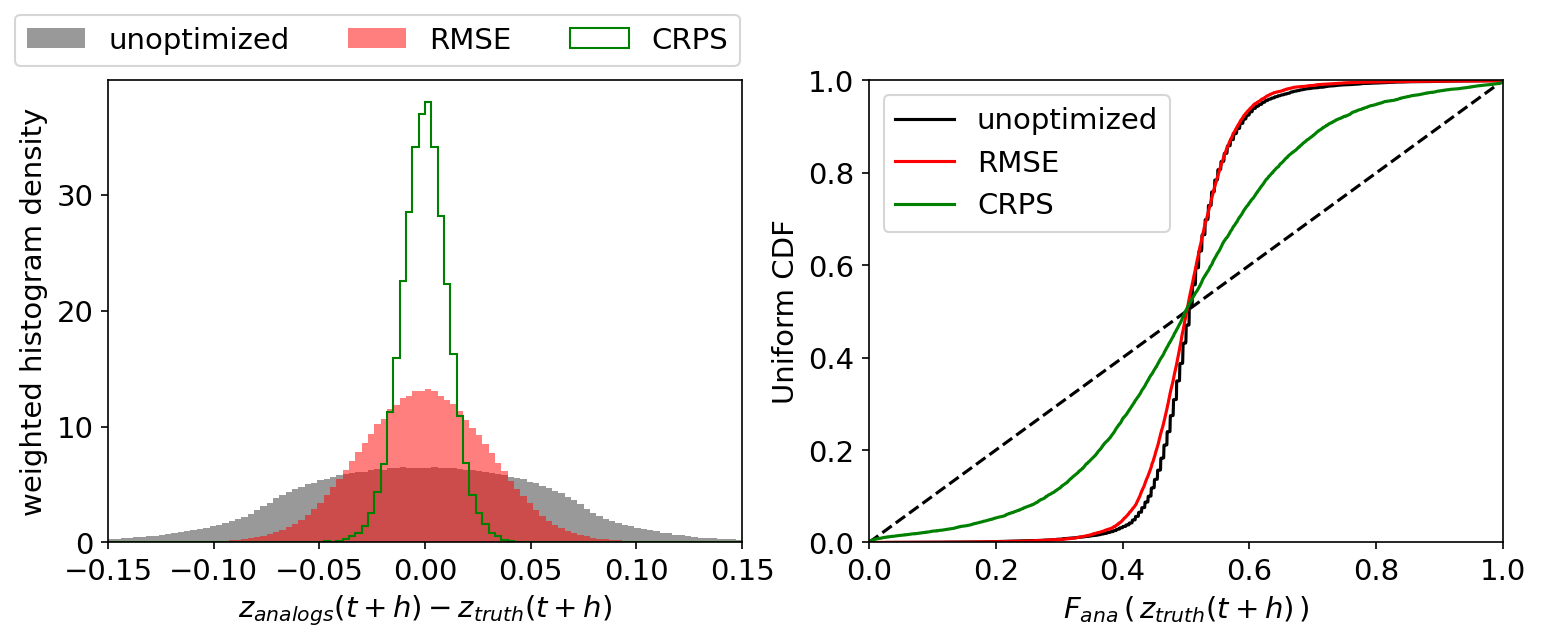

In [9]:
plt.figure(figsize=(12,4), dpi=150)

plt.subplot(121)

nbins = 100; rangehist = [-.15,.15]
plt.hist(np.ndarray.flatten( traj_norm[ind_init*int(tau/dt)+4,2].T
                            - traj_norm[4:Ntest*int(tau/dt):int(tau/dt),2] ) ,
         weights = None, bins=nbins, range=rangehist,
        histtype='bar', density=True, color='k', alpha=.4, label='unoptimized')
plt.hist(np.ndarray.flatten( traj_norm[ind_rmse_z*int(tau/dt)+4,2].T
                            - traj_norm[4:Ntest*int(tau/dt):int(tau/dt),2] ) ,
         weights = np.ndarray.flatten( p_rmse_z.T ), bins=nbins, range=rangehist,
        histtype='stepfilled', density=True, color='r', alpha=.5, label='RMSE')
plt.hist(np.ndarray.flatten( traj_norm[ind_crps_z*int(tau/dt)+4,2].T
                            - traj_norm[4:Ntest*int(tau/dt):int(tau/dt),2] ) ,
         weights = np.ndarray.flatten( p_crps_z.T ), bins=nbins, range=rangehist,
        histtype='step', density=True, color='g', label='CRPS')
plt.xlabel(r'$z_{analogs}(t+h)-z_{truth}(t+h)$')
plt.ylabel('weighted histogram density')
plt.legend(ncol=3, bbox_to_anchor=(1.02, 1.), loc=4)
plt.xlim(rangehist)

plt.subplot(122)

plt.plot([0,1], [0,1], '--k')
plt.plot(np.sort(Finit), np.arange(Ntest)/Ntest , 'k', label = "unoptimized")
plt.plot(np.sort(Frmse), np.arange(Ntest)/Ntest , 'r', label = 'RMSE')
plt.plot(np.sort(Fcrps), np.arange(Ntest)/Ntest , 'g', label = 'CRPS')
plt.xlim([0,1]); plt.ylim([0,1]); plt.legend()
plt.ylabel('Uniform CDF'); plt.xlabel(r'$F_{ana} \, (\, z_{truth}(t+h) \, )$')

plt.show()